In [1]:
%matplotlib inline
%load_ext rpy2.ipython

In [4]:
%%R
#source("https://bioconductor.org/biocLite.R")
#biocLite("DESeq2")
# Don't need to do this every time

/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Bioconductor version 3.4 (BiocInstaller 1.24.0), ?biocLite for help

  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: BioC_mirror: https://bioconductor.org

  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Using Bioconductor 3.4 (BiocInstaller 1.24.0), R 3.3.1 (2016-06-21).

  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Installing package(s) ‘DESeq2’

  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: also installing the dependencies ‘lambda.r’, ‘futile.options’, ‘RSQLite’, ‘XML’, ‘RCurl’, ‘GenomeInfoDb’, ‘futile.logger’, ‘snow’, ‘AnnotationDbi’, ‘annotate’, ‘GenomicRanges’, ‘Summariz

a


/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: also installing the dependencies ‘htmlTable’, ‘viridis’


  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Do you want to install from sources the package which needs compilation?

  warnings.warn(x, RRuntimeWarning)


y/n: y


/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: trying URL 'https://cran.rstudio.com/bin/macosx/mavericks/contrib/3.3/htmlTable_1.7.tgz'

  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  length 167635 bytes (163 KB)

  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: downloaded 163 KB


  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: trying URL 'https://cran.rstudio.com/bin/macosx/mavericks/contrib/3.3/viridis_0.3.4.tgz'

  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  length 1746084 bytes (1.7 MB)

  warnings.warn(x, RRuntimeWarning)
/opt/virt_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: tryin


The downloaded binary packages are in
	/var/folders/d2/qqsv2qxd5fjf4k455pzytwgh0000gn/T//Rtmpkp2lRN/downloaded_packages
Update all/some/none? [a/s/n]: 
  There is a binary version available but the source version is later:
     binary source needs_compilation
Rcpp 0.12.7 0.12.8              TRUE


The downloaded binary packages are in
	/var/folders/d2/qqsv2qxd5fjf4k455pzytwgh0000gn/T//Rtmpkp2lRN/downloaded_packages


In [2]:
%%R
# loading R packages
library(DESeq2)
library(phyloseq)
library(plyr)
library(dplyr)
#dplyr needs to come in last
library(ggplot2)
library(doParallel)
library(rwantshue)
library(RColorBrewer)

/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: S4Vectors

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘BiocGenerics’


  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked fro

In [3]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", "../../SeqData/trees/fulltree.tre", parseFunction = parse_taxonomy_greengenes)

In [4]:
%%R
# Creating a matrix with the different combinations of variables for day and amendment
#variables = expand.grid(Trtmt = c("X","N"), Day = c(0,1,2,3,5,7))
variables = levels(as.factor(sample_data(physeq)$Day))
variables = variables[variables!="0"]
variables

[1] "1" "2" "3" "5" "7"


There are a couple of possible comparisons:  
X vs N at each timepoint  
Each timepoint vs 0 bulk soil timepoint  
For bulk the timepoint approach makes sense, but for N, not quite...  
Start with all samples vs. bulk X trtmt

In [5]:
%%R
head(sample_data(physeq))

Sample Data:        [6 samples by 3 sample variables]:
    Cosm Trtmt Day
27     6     N   2
57    23     N   7
35     6     N   0
59    23     N   0
91     5     X   5
133   27     N   2


Questions include whether controlling for cosm helps; and whether day should be factor or numeric

In [29]:
%%R
#run deseq on each subset of factors (day and amendment), return the factors, OTU ID, base mean, log2-fold change, 
# the standard error, and the p value associated with the response.
Dif_Abund = function(Day){
    physeq.pruned = prune_samples(((sample_data(physeq)$Day == Day) | (sample_data(physeq)$Day == 0)),physeq)
    taxonomy = data.frame(tax_table(physeq.pruned))
    sampledata = data.frame(sample_data(physeq.pruned))
    dseq = phyloseq_to_deseq2(physeq.pruned, ~Day)
    #dseq$Day = factor(dseq$Day)
    dseq$Day = relevel(dseq$Day,"0")
    dseq$Cosm = factor(dseq$Cosm)
    design(dseq) = formula(~Day)
    dseq = DESeq(dseq, quiet = TRUE, fitType = "local")
    results = results(dseq, cooksCutoff=TRUE)
# Change Cooks Cutoff to control outliers or not
    results$Day = Day
    results = data.frame(results$Day,rownames(results),results$baseMean,results$log2FoldChange,results$lfcSE,results$pvalue,taxonomy[,1:7])
    colnames(results) = c("Day","OTU","baseMean","l2FC","SE","pvalue","Kingdom","Phylum","Class","Order","Family","Genus","Species")
    results
    }
# Note: this function throws an error based on calculating the geometric mean for samples with very low OTU counts
# Thus, we added the prune_samples step above, removing any samples with fewer than X counts.

In [30]:
%%R
# Joining the variables and the differential abundance
DA<-mdply(variables,Dif_Abund)

# Runs the  differential abundance function we created above with Day as a categorical factor.
# Could also try numeric factor, but since 7 looks different from 2-5, better to use categorical

In [31]:
%%R
threshold = function (thresh){
    dplyr::filter(DA, baseMean >= thresh) %>% 
    dplyr::mutate(padj = p.adjust(pvalue,"BH")) %>%
    dplyr::summarize(cutoff=thresh, count=sum(padj<=0.10, na.rm = TRUE))
}
# Takes our table of differential abundance values,
# and determines those for which the baseMean values is greater or equal to whatever we input as threshould
# Then, for any samples that meet that criterion, we add a column (mutate), where we adjust the p value 
# using the Benjamini & Hochberg correction
# Then we summarize the results, listing the cutoff threshold, and then the total number of OTUs for which the 
# new adjusted p values is less than 0.10 (just a standard level used by others).
# Note we also specify that the functions are called using dplyr package ("dplyr::").

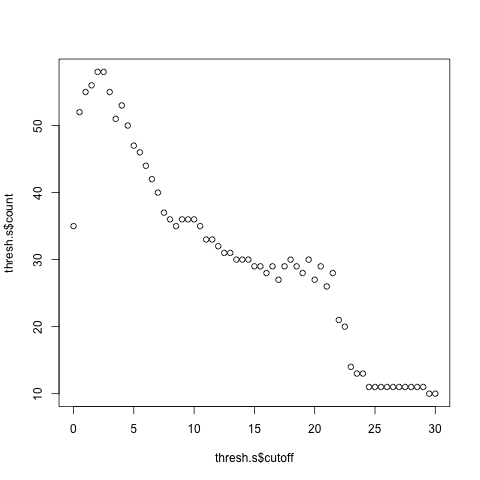

In [32]:
%%R
range = seq(0,30,0.5)
# Creates a range of numbers we are interested in for adjusted p values
thresh.s <- ldply(range, threshold)
# Applys the Threshold function we created above to the range of numbers we created above.

plot(thresh.s$count~thresh.s$cutoff)
# We can plot the threshold for base Mean value against the number of samples that will pass under this cutoff.
# We can see the optimum value to use here (here, 1.7)

In [22]:
%%R
class(DA$Day)

[1] "factor"


In [33]:
%%R
group_by(DA, Day) %>%
    mutate(Total=sum(baseMean)) %>%
    filter(baseMean>=3) %>% 
    mutate(padj = p.adjust(pvalue,"BH")) %>% 
    write.csv("../../SeqData/l2fcDay.Numeric.csv", row.names=FALSE)
# We take that differential abundance table we created above, and filter it to include only those samples 
# that had a baseMean value above the optimal cutoff we determined above.
# We then adjust the p values and save it as a csv.

In [34]:
%%R
l2fc<-read.csv("../../SeqData/l2fcDay.Numeric.csv")

In [35]:
%%R
dim(l2fc[is.na(l2fc$padj)==TRUE,])/(dim(l2fc[is.na(l2fc$padj)==FALSE,])+dim(l2fc[is.na(l2fc$padj)==TRUE,]))
# Fraction of OTUs that were designated as "outliers" 

[1] 0.0 0.5


In [36]:
%%R
m = l2fc %>%
    group_by(Day)%>%
    summarize(SumTotal=sum(baseMean))
m

# A tibble: 5 × 2
    Day SumTotal
  <int>    <dbl>
1     1 28301.04
2     2 25142.28
3     3 27046.55
4     5 28667.68
5     7 28690.57


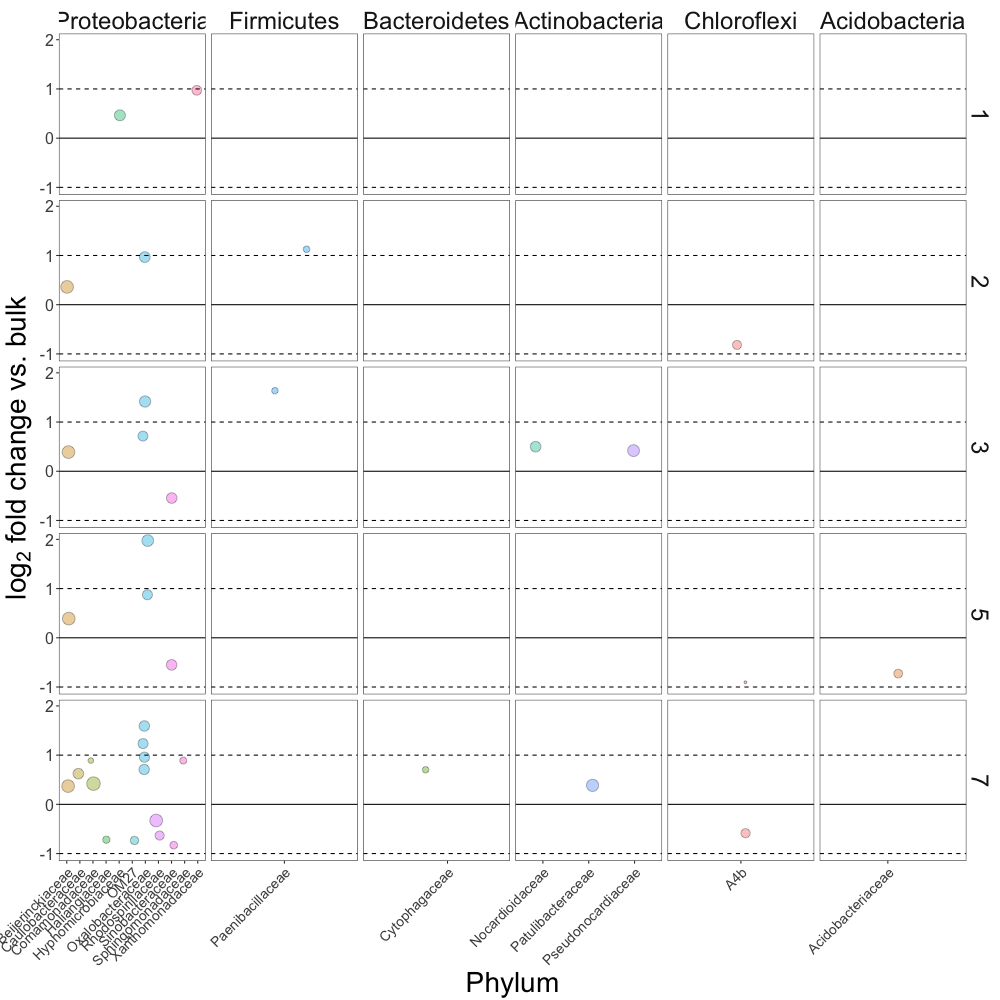

In [37]:
%%R -w 1000 -h 1000
# setting the image sizes, then making the figure...

FDR = 0.1

d = l2fc%>%
    group_by(Day) %>%
    mutate(sig = ifelse(padj<=FDR,1,0))%>%
    mutate(relabund=baseMean/sum(baseMean))%>%
    filter(Family!="mitochondria")%>%
    filter(Class!="Chloroplast")%>%
    filter(pvalue != 'NA')%>%
    filter(sig==1)
# This compares it to the whole sample, not just the signficantly increased subset in l2fc
    
max.l2FC = ddply(d, .(Phylum), summarize, M = max(l2FC))
# makes a dataframe with the maximum value of log2Fold change for each phylum
d$Phylum = factor(d$Phylum, max.l2FC[order(-max.l2FC$M),]$Phylum)
# takes our phylum column, and arranges it in order of our log2FoldChange values

#d$Trtmt = ordered(d$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction"))
    
p = ggplot(d, aes(x = Family, y = l2FC, fill = Phylum, size = relabund))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.

p = p + facet_grid(~Day~Phylum,scales="free_x")
# saying we want it to present the data separately for our two variables (trtmt and month), in 2 columns

d$sig = as.factor(d$sig)
    
d.yes = d[d$sig==1,]
d.no = d[d$sig==0,]
    
p = p + geom_point(data=d.yes, aes(x = Family, y = l2FC, fill = Family, size=relabund), shape = 21, alpha=0.4, position = position_jitter(w = 0.20))
#p = p + geom_point(data=d.no, aes(x = Phylum, y = l2FC, fill = sig, size=relabund), shape = 21, alpha=0.3, position = position_jitter(w = 0.20))

    
#p = p + geom_point(shape = 21, alpha=0.45, position = position_jitter(w = 0.20), aes(size = relabund))
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other

p = p + scale_size_continuous("log(Relative\nAbundance)",trans="log",guide="none")
    
p = p + geom_hline(yintercept = 1, linetype=2)
p = p + geom_hline(yintercept = -1, linetype=2)
p = p + geom_hline(yintercept = 0.0, linetype=1)
# puts in horizontal lines at reference values

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 24),
              strip.text.y = element_text(size = 24),
              axis.text.x = element_text(size = 14, angle = 45, hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 28),
              axis.text.y = element_text(size=16),
              axis.title.y = element_text(size = 28),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "Phylum")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," fold change vs. bulk",sep="")))
# sets the label for the y axes.
    
#colourCount = 10
#getPalette = colorRampPalette(brewer.pal(8, "Spectral"))
#p = p + scale_fill_manual(guide="none", values=c("grey",paste(getPalette(colourCount))))
#p = p + scale_fill_manual(guide="none", values=c(paste(getPalette(colourCount))))


#p = p + scale_color_continuous(trans="log")    
p = p + scale_fill_discrete(guide="none")


p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines
    
p

In [17]:
%%R
ggsave(filename="CosmFactor.jpg", plot=p ,width=11.5, height=8)

In [40]:
%%R
l2fc[l2fc$padj<0.1,]

     X1 Day            OTU  baseMean       l2FC         SE       pvalue
373   2   2     16SW57_804 441.97872  0.1366543 0.05443740 1.206282e-02
380   2   2     16SW57_501  69.93303  0.3657182 0.11121246 1.007355e-03
403   2   2    16SW57_2894  76.72771 -0.3211771 0.11033674 3.604117e-03
422   2   2    16SW57_2975  34.92844  0.8226244 0.20235626 4.798551e-05
453   2   2     16SW57_965  30.87475 -0.4724385 0.14378657 1.017319e-03
455   2   2    16SW57_1212 192.09782 -0.3820540 0.09322491 4.163816e-05
456   2   2    16SW57_5463  99.47899 -0.4517486 0.11354981 6.937530e-05
457   2   2     16SW57_845 327.78216 -0.3505470 0.08665168 5.221758e-05
463   2   2    16SW57_4085  72.09137 -0.3510640 0.12551825 5.159287e-03
482   2   2   16SW57_19640  20.88251  0.4397294 0.15942981 5.813164e-03
484   2   2    16SW57_1531  90.44392  0.3013316 0.10814358 5.329658e-03
489   2   2     16SW57_622 218.54112  0.2504349 0.08190065 2.229767e-03
490   2   2 16SW145_126274  50.59021  0.4516013 0.12875795 4.525

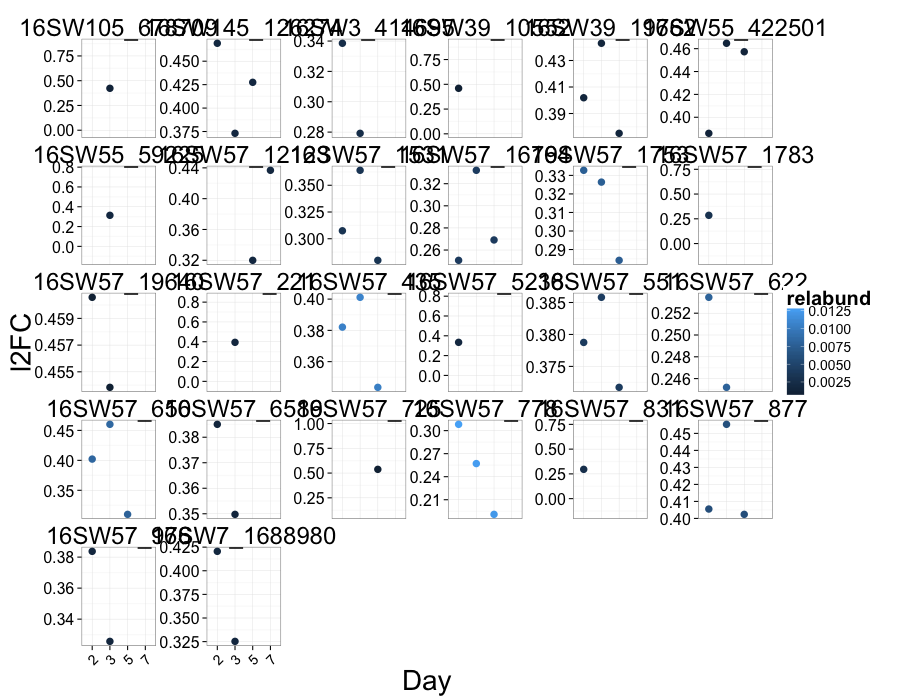

In [45]:
%%R -w 900 -h 700

FDR = 0.1

d = l2fc%>%
    group_by(Day) %>%
    filter(padj<=FDR)%>%
    mutate(relabund=baseMean/Total)%>%
    filter(Family!="mitochondria")%>%
    filter(Class!="Chloroplast")%>%
    filter(Phylum=="Actinobacteria")%>%
    filter(pvalue != 'NA')
# This compares it to the whole sample, not just the signficantly increased subset in l2fc
d$Day = as.factor(d$Day)

p = ggplot(d, aes(x = Day, y = l2FC, colour = relabund))
p = p + geom_point(size = 3.5)

p = p + theme_bw()
p = p + theme(strip.text.x = element_text(size = 24),
              strip.text.y = element_text(size = 24),
              axis.text.x = element_text(size = 14, angle = 45, hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 28),
              axis.text.y = element_text(size=16),
              axis.title.y = element_text(size = 28),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank())
p = p + facet_wrap(~OTU, scales="free_y")


p

In [43]:
!grep "16SW57_804" -4 ../../SeqData/otus.fasta

TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGTCCTTTAAGTCTGATGTGAAAGCCC
ACGGCTCAACCGTGGAGGGTCATTGGAAACTGGGGGACTTGAGTACAGAAGAGAAGAGTGGAATTCCACGTGTAGCGGTG
AAATGCGTAGAGATGTGGAGGAACACCAGTGGCGAAGGCGACTCTTTGGTCTGTAACTGACGCTGAGGCGCGAAAGCGTG
GGGAGCAAACAG
>16SW57_804
TACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTTTGTAAGTTAGAGGTGAAAGCCC
GGGGCTCAACTCCGGAATTGCCTTTAAGACTGCATCGCTAGAATTGTGGAGAGGTAAGTGGAATTCCGAGTGTAGAGGTG
AAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGACTTACTGGACACATATTGACGCTGAGGTGCGAAAGCGTG
GGGAGCAAACAG


16SW57_2975 is closest in NCBI Blast to Telluria mixta (close to Pseudomonas chitinolytica)  
HeteroT, use starch and xylan, but not cellulose; Active polySacc degraders. Mixta likely doesn't degrade chitin.  
  
16SW57_804 is closest in NCBI blast to a Sphingomonas sp. This OTU is abundant, and does increase significantly (but not by a lot). HeteroT, aerobic.

In [46]:
%%R
head(l2fc)

  X1 Day         OTU  baseMean         l2FC         SE    pvalue  Kingdom
1  1   1 16SW57_3653  27.02036 -0.039549188 0.15124210 0.7937101 Bacteria
2  1   1  16SW57_427 131.87107 -0.025490128 0.09531486 0.7891375 Bacteria
3  1   1 16SW57_1967  27.95696  0.066701958 0.14274164 0.6402913 Bacteria
4  1   1 16SW57_4254  76.34845 -0.009058212 0.10303819 0.9299472 Bacteria
5  1   1 16SW57_3143  19.95133  0.014894843 0.14963668 0.9207095 Bacteria
6  1   1  16SW57_441  30.02567  0.092287435 0.13698183 0.5004892 Bacteria
          Phylum               Class        Order        Family Genus Species
1 Proteobacteria Deltaproteobacteria Myxococcales          <NA>  <NA>    <NA>
2 Proteobacteria Deltaproteobacteria Myxococcales Myxococcaceae  <NA>    <NA>
3 Proteobacteria Deltaproteobacteria Myxococcales Myxococcaceae  <NA>    <NA>
4 Proteobacteria Deltaproteobacteria Myxococcales Myxococcaceae  <NA>    <NA>
5 Proteobacteria Deltaproteobacteria Myxococcales          <NA>  <NA>    <NA>
6 Proteobacter

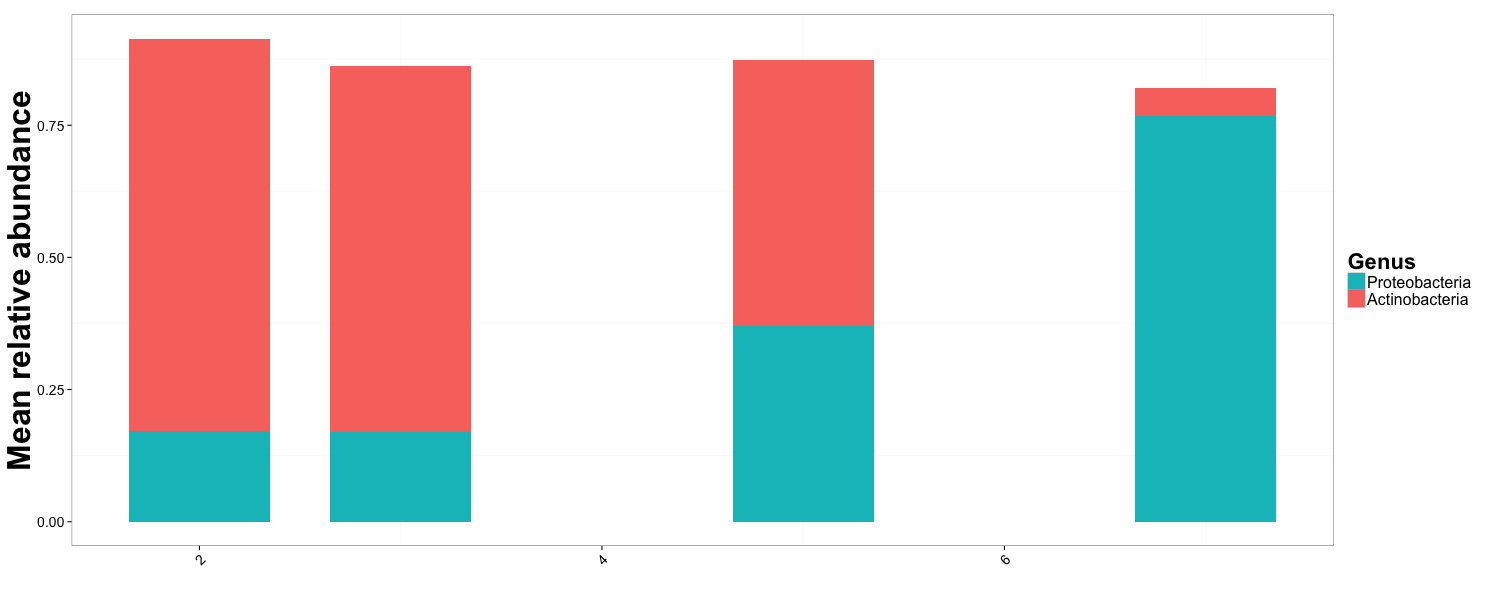

In [47]:
%%R -w 1500 -h 600

FDR = 0.1

d = l2fc%>%
    filter(l2FC>0)%>%
    group_by(Day) %>%
    filter(padj<=FDR)%>%
    mutate(relabund=baseMean/sum(baseMean))%>%
#    filter(Class=="Actinobacteria")%>%
    filter(Family!="mitochondria")%>%
    filter(Class!="Chloroplast")%>%
    filter(pvalue != 'NA')

p = ggplot(d, aes(x = Day, y = relabund, fill = Phylum))

#p = p + facet_grid(~Family, scales = "free_x", space = "free")

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(ncol = 1, title = "Genus", reverse="TRUE"))

#p = p + theme(axis.text.y=theme_text(angle=-90))

p = p + ylab("Mean relative abundance") + xlab("")

p = p + theme_bw()

p = p + theme(axis.text.x = element_text(size = 14, angle = 45, hjust=1),
              axis.text.y = element_text(size = 14), 
              axis.title.x = element_text(size = 28),
              axis.title.y = element_text(size = 32,vjust=1,face='bold'),
              legend.title = element_text(size=22),
              legend.text = element_text(size = 16))

p = p + theme(legend.position="right", panel.grid.major= element_blank())

p

In [57]:
%%R
ggsave(filename="DiffAbund16SMonths.jpg", plot=p ,width=11.5, height=8)

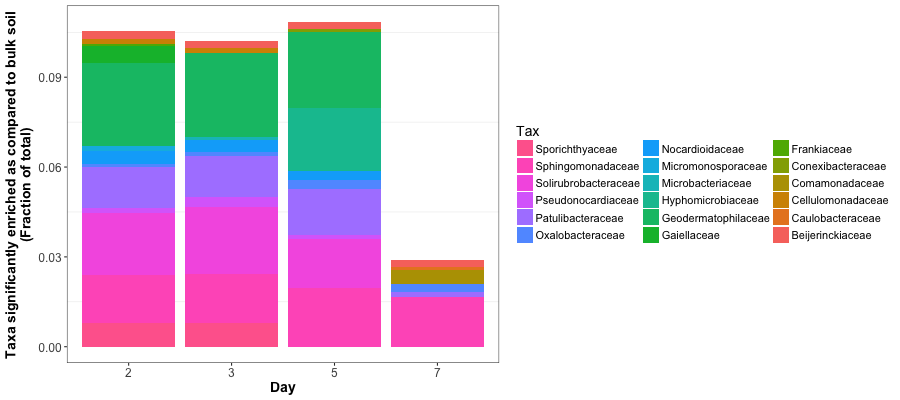

In [15]:
%%R -w 900 -h 400

FDR=0.1
cutoff = 0
l2fc$Day=as.factor(l2fc$Day)

d = l2fc %>%
    filter(padj<=FDR)%>%
    filter(l2FC>cutoff)%>%
    filter(Family!="mitochondria")%>%
    filter(Class!="Chloroplast")%>%
    mutate(Tax=Family)%>%
    mutate(Relabund=baseMean/Total)%>%
    group_by(Day,Tax)%>%
    summarize(RelabundTot=sum(Relabund))

p = ggplot(d, aes(x=Day, y=RelabundTot, fill = Tax))

p = p + geom_bar(stat = "identity", width = 0.90)

p = p + guides(fill = guide_legend(title="Tax", ncol = 3, reverse=TRUE))

p = p + xlab("Day") + ylab("Taxa significantly enriched as compared to bulk soil\n(Fraction of total)")

p = p + theme_bw()

p = p + theme(axis.title = element_text(size=14,face="bold"))
p = p + theme(axis.text = element_text(size=12,))
p = p + theme(legend.text=element_text(size=11), legend.title=element_text(size=14), legend.position="right")
p = p + theme(strip.background = element_blank(),strip.text = element_text(size=14), panel.grid.major= element_blank())

p